In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [35]:
!ls

datalab  drive


In [36]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
import keras
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
%matplotlib inline

In [0]:
data_path = 'drive/projects/QuoteGen/data'
if not os.path.exists(data_path):
  os.mkdir(data_path)

In [0]:
models_path = 'drive/projects/QuoteGen/models'
if not os.path.exists(models_path):
  os.mkdir(models_path)

In [0]:
data_txt = os.path.join(data_path, 'quotes.txt')
data_csv = os.path.join(data_path, 'quotes_all.csv')

In [41]:
quotes_ds = []
if os.path.exists(os.path.join(data_path,"quotes_pickle.pkl")):
  with open(os.path.join(data_path,"quotes_pickle.pkl"),'rb') as f:
    quotes_ds = pickle.load(f)
else:
  with open(data_csv) as f:
    for line in f.readlines():
      quotes_ds.append(line.split(";")[0])
  # Pickling the dataset
  if not os.path.exists(os.path.join(data_path,'quotes_pickle.pkl')):
    out = open(os.path.join(data_path,"quotes_pickle.pkl"),'wb')
    pickle.dump(quotes_ds, out)
print("Found %d quotes"%len(quotes_ds))

Found 75966 quotes


In [0]:
def clean_sentences(sentences):
    n_sentences=[]
    temp = ''
    for sentence in sentences:
      temp = "\t "+sentence+ " \n"
      n_sentences.append(temp)
      temp=''
    return n_sentences

In [0]:
cleaned_quotes = clean_sentences(quotes_ds)

In [44]:
cleaned_quotes[0]

"\t Age is an issue of mind over matter. If you don't mind, it doesn't matter. \n"

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [46]:
tokenizer = Tokenizer(lower=True, split=' ', char_level=True)
tokenizer.fit_on_texts(cleaned_quotes)
sequences = tokenizer.texts_to_sequences(cleaned_quotes)

word_index = tokenizer.word_index
print('Found %d unique tokens.' % len(word_index))

Found 83 unique tokens.


In [0]:
index2char = {}
for ch in tokenizer.word_index:
  index2char[tokenizer.word_index.get(ch)] = ch

In [48]:
test = sequences[0]
s = ""
for temp in test:
  if not temp==0:
    s = s+ index2char[temp]
    
cleaned_quotes[0],s

("\t Age is an issue of mind over matter. If you don't mind, it doesn't matter. \n",
 "\t Age is an issue of mind over matter. If you don't mind, it doesn't matter. \n")

In [54]:
quotes_ds[0]

"Age is an issue of mind over matter. If you don't mind, it doesn't matter."

In [0]:
def generate_split(data, lookback= 20, step = 5):
  sentence = []
  next_char = []
  for d in data: 
    for i in range(lookback,len(d), step):
      sentence.append(d[i-lookback:i])
      next_char.append(d[i])
  return sentence, next_char

In [0]:
sentence, next_char = generate_split(quotes_ds)

In [0]:
max_len = 20
n_samples = 120000

x = np.zeros((n_samples, max_len, len(word_index)))
y = np.zeros((n_samples, len(word_index)))

for i,s in enumerate(sentence[:n_samples]):
  for t, char in enumerate(s):
      x[i, t, word_index[char]] = 1
  y[i, word_index[next_char[i]]] = 1

In [0]:
from keras.models import Sequential
from keras import Model
from keras.layers import Input, Embedding, LSTM, Dense, Flatten,Dropout
from keras.optimizers import RMSprop
from keras.models import load_model

In [0]:
model = Sequential()
model.add(LSTM(128, input_shape=(max_len, len(word_index))))
model.add(Dense(len(word_index), activation='softmax'))

In [0]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
callbacks_list = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.1,
            patience=10,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(models_path,'quotegen.h5'),
            monitor='loss',
            save_best_only=True,
        ),
]

In [176]:
model = load_model(os.path.join(models_path,'quotegen.h5'))
history = model.fit(x, y, batch_size=256, epochs=150,  validation_split=0.1, callbacks= callbacks_list)

Train on 108000 samples, validate on 12000 samples
Epoch 1/150
108000/108000 [==============================] - 30s 275us/step - loss: 0.9651 - val_loss: 1.8564
Epoch 2/150
 39424/108000 [=========>....................] - ETA: 17s - loss: 0.9324

108000/108000 [==============================] - 29s 267us/step - loss: 0.9635 - val_loss: 1.8549
Epoch 3/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9639

108000/108000 [==============================] - 29s 266us/step - loss: 0.9648 - val_loss: 1.8795
Epoch 4/150
108000/108000 [==============================] - 28s 263us/step - loss: 0.9603 - val_loss: 1.8810
Epoch 5/150
 15360/108000 [===>..........................] - ETA: 23s - loss: 0.9170

108000/108000 [==============================] - 28s 263us/step - loss: 0.9593 - val_loss: 1.8867
Epoch 6/150
 96256/108000 [=========================>....] - ETA: 2s - loss: 0.9507

108000/108000 [==============================] - 28s 263us/step - loss: 0.9554 - val_loss: 1.9030
Epoch 7/150
108000/108000 [==============================] - 29s 268us/step - loss: 0.9550 - val_loss: 1.9051
Epoch 8/150
 12800/108000 [==>...........................] - ETA: 25s - loss: 0.9167

108000/108000 [==============================] - 29s 268us/step - loss: 0.9545 - val_loss: 1.8929
Epoch 9/150
 99584/108000 [==========================>...] - ETA: 2s - loss: 0.9495

108000/108000 [==============================] - 30s 277us/step - loss: 0.9523 - val_loss: 1.9277
Epoch 10/150
108000/108000 [==============================] - 31s 284us/step - loss: 0.9516 - val_loss: 1.8937
Epoch 11/150
 16896/108000 [===>..........................] - ETA: 28s - loss: 0.9035

108000/108000 [==============================] - 35s 320us/step - loss: 0.9483 - val_loss: 1.9451
Epoch 12/150
104192/108000 [===========================>..] - ETA: 1s - loss: 0.9476

108000/108000 [==============================] - 35s 327us/step - loss: 0.9493 - val_loss: 1.9467
Epoch 13/150
108000/108000 [==============================] - 35s 327us/step - loss: 0.9471 - val_loss: 1.9536
Epoch 14/150
 18688/108000 [====>.........................] - ETA: 27s - loss: 0.9117

108000/108000 [==============================] - 34s 318us/step - loss: 0.9464 - val_loss: 1.9390
Epoch 15/150
104704/108000 [============================>.] - ETA: 0s - loss: 0.9403

108000/108000 [==============================] - 34s 312us/step - loss: 0.9415 - val_loss: 1.9142
Epoch 16/150
108000/108000 [==============================] - 34s 314us/step - loss: 0.9395 - val_loss: 1.9093
Epoch 17/150
 18688/108000 [====>.........................] - ETA: 27s - loss: 0.8791

108000/108000 [==============================] - 34s 315us/step - loss: 0.9395 - val_loss: 1.9181
Epoch 18/150
104704/108000 [============================>.] - ETA: 0s - loss: 0.9363

108000/108000 [==============================] - 34s 312us/step - loss: 0.9384 - val_loss: 1.9382
Epoch 19/150
108000/108000 [==============================] - 34s 316us/step - loss: 0.9366 - val_loss: 1.9351
Epoch 20/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8840

108000/108000 [==============================] - 34s 311us/step - loss: 0.9369 - val_loss: 1.9287
Epoch 21/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9350

108000/108000 [==============================] - 34s 314us/step - loss: 0.9364 - val_loss: 1.9346
Epoch 22/150
108000/108000 [==============================] - 35s 321us/step - loss: 0.9328 - val_loss: 1.9368
Epoch 23/150
 18944/108000 [====>.........................] - ETA: 28s - loss: 0.8825

108000/108000 [==============================] - 35s 323us/step - loss: 0.9311 - val_loss: 1.9448
Epoch 24/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9317

108000/108000 [==============================] - 35s 325us/step - loss: 0.9322 - val_loss: 1.9791
Epoch 25/150
108000/108000 [==============================] - 35s 320us/step - loss: 0.9287 - val_loss: 1.9658
Epoch 26/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8835

108000/108000 [==============================] - 35s 320us/step - loss: 0.9304 - val_loss: 1.9307
Epoch 27/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9262

108000/108000 [==============================] - 35s 324us/step - loss: 0.9288 - val_loss: 1.9413
Epoch 28/150
108000/108000 [==============================] - 35s 324us/step - loss: 0.9247 - val_loss: 1.9281
Epoch 29/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8786

108000/108000 [==============================] - 34s 319us/step - loss: 0.9248 - val_loss: 1.9753
Epoch 30/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9230

108000/108000 [==============================] - 35s 320us/step - loss: 0.9240 - val_loss: 1.9685
Epoch 31/150
108000/108000 [==============================] - 35s 323us/step - loss: 0.9228 - val_loss: 1.9312
Epoch 32/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8894

108000/108000 [==============================] - 35s 320us/step - loss: 0.9235 - val_loss: 1.9460
Epoch 33/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9171

108000/108000 [==============================] - 34s 315us/step - loss: 0.9185 - val_loss: 1.9682
Epoch 34/150
108000/108000 [==============================] - 34s 316us/step - loss: 0.9217 - val_loss: 1.9472
Epoch 35/150
 18944/108000 [====>.........................] - ETA: 28s - loss: 0.8623

108000/108000 [==============================] - 35s 324us/step - loss: 0.9140 - val_loss: 1.9728
Epoch 36/150
104448/108000 [============================>.] - ETA: 1s - loss: 0.9143

108000/108000 [==============================] - 34s 315us/step - loss: 0.9156 - val_loss: 1.9658
Epoch 37/150
108000/108000 [==============================] - 34s 311us/step - loss: 0.9154 - val_loss: 1.9774
Epoch 38/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8562

108000/108000 [==============================] - 34s 311us/step - loss: 0.9138 - val_loss: 1.9639
Epoch 39/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9128

108000/108000 [==============================] - 34s 317us/step - loss: 0.9136 - val_loss: 1.9745
Epoch 40/150
108000/108000 [==============================] - 33s 307us/step - loss: 0.9122 - val_loss: 1.9704
Epoch 41/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8591

108000/108000 [==============================] - 33s 306us/step - loss: 0.9150 - val_loss: 2.0061
Epoch 42/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9066

108000/108000 [==============================] - 34s 313us/step - loss: 0.9079 - val_loss: 1.9620
Epoch 43/150
108000/108000 [==============================] - 35s 325us/step - loss: 0.9088 - val_loss: 1.9951
Epoch 44/150
 18944/108000 [====>.........................] - ETA: 28s - loss: 0.8677

108000/108000 [==============================] - 34s 318us/step - loss: 0.9102 - val_loss: 1.9716
Epoch 45/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9074

108000/108000 [==============================] - 35s 323us/step - loss: 0.9082 - val_loss: 2.0129
Epoch 46/150
108000/108000 [==============================] - 35s 322us/step - loss: 0.9090 - val_loss: 1.9821
Epoch 47/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8560

108000/108000 [==============================] - 34s 315us/step - loss: 0.9068 - val_loss: 1.9775
Epoch 48/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9064

108000/108000 [==============================] - 33s 309us/step - loss: 0.9075 - val_loss: 1.9834
Epoch 49/150
108000/108000 [==============================] - 34s 311us/step - loss: 0.9062 - val_loss: 1.9723
Epoch 50/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8505

108000/108000 [==============================] - 34s 314us/step - loss: 0.9018 - val_loss: 2.0305
Epoch 51/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.9008

108000/108000 [==============================] - 34s 316us/step - loss: 0.9004 - val_loss: 2.0189
Epoch 52/150
108000/108000 [==============================] - 34s 313us/step - loss: 0.9019 - val_loss: 1.9905
Epoch 53/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8465

108000/108000 [==============================] - 34s 315us/step - loss: 0.8992 - val_loss: 2.0109
Epoch 54/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8988

108000/108000 [==============================] - 34s 312us/step - loss: 0.8993 - val_loss: 1.9980
Epoch 55/150
108000/108000 [==============================] - 33s 305us/step - loss: 0.8931 - val_loss: 2.0024
Epoch 56/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8521

108000/108000 [==============================] - 34s 312us/step - loss: 0.8957 - val_loss: 1.9961
Epoch 57/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8985

108000/108000 [==============================] - 33s 307us/step - loss: 0.8979 - val_loss: 2.0180
Epoch 58/150
108000/108000 [==============================] - 33s 305us/step - loss: 0.8948 - val_loss: 1.9990
Epoch 59/150
 18944/108000 [====>.........................] - ETA: 26s - loss: 0.8478

108000/108000 [==============================] - 33s 304us/step - loss: 0.8946 - val_loss: 2.0083
Epoch 60/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8899

108000/108000 [==============================] - 33s 309us/step - loss: 0.8908 - val_loss: 1.9692
Epoch 61/150
108000/108000 [==============================] - 33s 308us/step - loss: 0.8934 - val_loss: 2.0053
Epoch 62/150
 18944/108000 [====>.........................] - ETA: 26s - loss: 0.8610

108000/108000 [==============================] - 33s 309us/step - loss: 0.8928 - val_loss: 1.9944
Epoch 63/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8917

108000/108000 [==============================] - 34s 310us/step - loss: 0.8925 - val_loss: 2.0346
Epoch 64/150
108000/108000 [==============================] - 33s 308us/step - loss: 0.8879 - val_loss: 2.0286
Epoch 65/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8409

108000/108000 [==============================] - 34s 311us/step - loss: 0.8888 - val_loss: 2.0225
Epoch 66/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8879

108000/108000 [==============================] - 34s 316us/step - loss: 0.8890 - val_loss: 2.0378
Epoch 67/150
108000/108000 [==============================] - 34s 315us/step - loss: 0.8894 - val_loss: 2.0130
Epoch 68/150
 18944/108000 [====>.........................] - ETA: 26s - loss: 0.8374

108000/108000 [==============================] - 34s 311us/step - loss: 0.8856 - val_loss: 2.0107
Epoch 69/150
105984/108000 [============================>.] - ETA: 0s - loss: 0.8857

108000/108000 [==============================] - 34s 317us/step - loss: 0.8867 - val_loss: 2.0443
Epoch 70/150
108000/108000 [==============================] - 35s 321us/step - loss: 0.8850 - val_loss: 2.0404
Epoch 71/150
 19200/108000 [====>.........................] - ETA: 26s - loss: 0.8388

108000/108000 [==============================] - 34s 314us/step - loss: 0.8853 - val_loss: 2.0366
Epoch 72/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8811

108000/108000 [==============================] - 34s 318us/step - loss: 0.8816 - val_loss: 2.0738
Epoch 73/150
108000/108000 [==============================] - 35s 320us/step - loss: 0.8845 - val_loss: 2.0193
Epoch 74/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8239

108000/108000 [==============================] - 34s 317us/step - loss: 0.8856 - val_loss: 2.0140
Epoch 75/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8804

108000/108000 [==============================] - 34s 314us/step - loss: 0.8823 - val_loss: 2.0164
Epoch 76/150
108000/108000 [==============================] - 33s 309us/step - loss: 0.8825 - val_loss: 2.0146
Epoch 77/150
 18944/108000 [====>.........................] - ETA: 26s - loss: 0.8341

108000/108000 [==============================] - 33s 305us/step - loss: 0.8825 - val_loss: 2.0053
Epoch 78/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8802

108000/108000 [==============================] - 33s 307us/step - loss: 0.8820 - val_loss: 2.0550
Epoch 79/150
108000/108000 [==============================] - 33s 302us/step - loss: 0.8813 - val_loss: 2.0343
Epoch 80/150
 18944/108000 [====>.........................] - ETA: 26s - loss: 0.8239

108000/108000 [==============================] - 33s 310us/step - loss: 0.8784 - val_loss: 2.0342
Epoch 81/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8756

108000/108000 [==============================] - 33s 306us/step - loss: 0.8764 - val_loss: 2.0074
Epoch 82/150
108000/108000 [==============================] - 33s 308us/step - loss: 0.8799 - val_loss: 2.0081
Epoch 83/150
 18944/108000 [====>.........................] - ETA: 26s - loss: 0.8280

108000/108000 [==============================] - 33s 303us/step - loss: 0.8736 - val_loss: 2.0259
Epoch 84/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8726

108000/108000 [==============================] - 33s 303us/step - loss: 0.8734 - val_loss: 2.0511
Epoch 85/150
108000/108000 [==============================] - 33s 310us/step - loss: 0.8757 - val_loss: 2.0649
Epoch 86/150
 18944/108000 [====>.........................] - ETA: 26s - loss: 0.8228

108000/108000 [==============================] - 33s 305us/step - loss: 0.8731 - val_loss: 2.0310
Epoch 87/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8729

108000/108000 [==============================] - 34s 312us/step - loss: 0.8737 - val_loss: 2.0867
Epoch 88/150
108000/108000 [==============================] - 33s 306us/step - loss: 0.8722 - val_loss: 2.0347
Epoch 89/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8119

108000/108000 [==============================] - 33s 309us/step - loss: 0.8691 - val_loss: 2.0629
Epoch 90/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8701

108000/108000 [==============================] - 33s 309us/step - loss: 0.8716 - val_loss: 2.0964
Epoch 91/150
108000/108000 [==============================] - 34s 313us/step - loss: 0.8711 - val_loss: 2.0276
Epoch 92/150
 18944/108000 [====>.........................] - ETA: 26s - loss: 0.8209

108000/108000 [==============================] - 33s 306us/step - loss: 0.8701 - val_loss: 2.0191
Epoch 93/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8659

108000/108000 [==============================] - 33s 307us/step - loss: 0.8675 - val_loss: 2.0858
Epoch 94/150
108000/108000 [==============================] - 33s 309us/step - loss: 0.8692 - val_loss: 2.0568
Epoch 95/150
 18944/108000 [====>.........................] - ETA: 27s - loss: 0.8108

108000/108000 [==============================] - 34s 316us/step - loss: 0.8665 - val_loss: 2.0657
Epoch 96/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8647

108000/108000 [==============================] - 35s 324us/step - loss: 0.8657 - val_loss: 2.0303
Epoch 97/150
108000/108000 [==============================] - 35s 322us/step - loss: 0.8654 - val_loss: 2.0441
Epoch 98/150
 18944/108000 [====>.........................] - ETA: 26s - loss: 0.8270

108000/108000 [==============================] - 35s 322us/step - loss: 0.8656 - val_loss: 2.0893
Epoch 99/150
104960/108000 [============================>.] - ETA: 0s - loss: 0.8628

108000/108000 [==============================] - 36s 333us/step - loss: 0.8644 - val_loss: 2.0690
Epoch 100/150
108000/108000 [==============================] - 35s 326us/step - loss: 0.8656 - val_loss: 2.0742
Epoch 101/150
 18432/108000 [====>.........................] - ETA: 27s - loss: 0.8155

108000/108000 [==============================] - 34s 319us/step - loss: 0.8595 - val_loss: 2.0572
Epoch 102/150
104192/108000 [===========================>..] - ETA: 1s - loss: 0.8631

108000/108000 [==============================] - 34s 316us/step - loss: 0.8641 - val_loss: 2.0738
Epoch 103/150
108000/108000 [==============================] - 35s 321us/step - loss: 0.8627 - val_loss: 2.0591
Epoch 104/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.8031

108000/108000 [==============================] - 34s 317us/step - loss: 0.8577 - val_loss: 2.0846
Epoch 105/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8575

108000/108000 [==============================] - 35s 323us/step - loss: 0.8589 - val_loss: 2.0776
Epoch 106/150
108000/108000 [==============================] - 34s 315us/step - loss: 0.8591 - val_loss: 2.1036
Epoch 107/150
 18176/108000 [====>.........................] - ETA: 26s - loss: 0.8066

108000/108000 [==============================] - 33s 307us/step - loss: 0.8599 - val_loss: 2.0610
Epoch 108/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8582

108000/108000 [==============================] - 33s 306us/step - loss: 0.8591 - val_loss: 2.0853
Epoch 109/150
108000/108000 [==============================] - 34s 318us/step - loss: 0.8597 - val_loss: 2.0774
Epoch 110/150
 18176/108000 [====>.........................] - ETA: 28s - loss: 0.8023

108000/108000 [==============================] - 35s 324us/step - loss: 0.8574 - val_loss: 2.0845
Epoch 111/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8549

108000/108000 [==============================] - 35s 325us/step - loss: 0.8564 - val_loss: 2.0729
Epoch 112/150
108000/108000 [==============================] - 35s 321us/step - loss: 0.8573 - val_loss: 2.0754
Epoch 113/150
 18176/108000 [====>.........................] - ETA: 28s - loss: 0.8277

108000/108000 [==============================] - 35s 322us/step - loss: 0.8558 - val_loss: 2.0451
Epoch 114/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8531

108000/108000 [==============================] - 34s 318us/step - loss: 0.8539 - val_loss: 2.0398
Epoch 115/150
108000/108000 [==============================] - 34s 318us/step - loss: 0.8541 - val_loss: 2.0756
Epoch 116/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.8035

108000/108000 [==============================] - 34s 314us/step - loss: 0.8559 - val_loss: 2.0857
Epoch 117/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8539

108000/108000 [==============================] - 34s 319us/step - loss: 0.8555 - val_loss: 2.1120
Epoch 118/150
108000/108000 [==============================] - 35s 322us/step - loss: 0.8562 - val_loss: 2.0893
Epoch 119/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.7987

108000/108000 [==============================] - 34s 313us/step - loss: 0.8560 - val_loss: 2.1441
Epoch 120/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8526

108000/108000 [==============================] - 34s 313us/step - loss: 0.8534 - val_loss: 2.0627
Epoch 121/150
108000/108000 [==============================] - 34s 314us/step - loss: 0.8512 - val_loss: 2.1311
Epoch 122/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.8084

108000/108000 [==============================] - 33s 310us/step - loss: 0.8550 - val_loss: 2.0753
Epoch 123/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8507

108000/108000 [==============================] - 33s 309us/step - loss: 0.8512 - val_loss: 2.1100
Epoch 124/150
108000/108000 [==============================] - 34s 316us/step - loss: 0.8547 - val_loss: 2.0579
Epoch 125/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.7895

108000/108000 [==============================] - 34s 319us/step - loss: 0.8496 - val_loss: 2.0842
Epoch 126/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8484

108000/108000 [==============================] - 34s 317us/step - loss: 0.8501 - val_loss: 2.0929
Epoch 127/150
108000/108000 [==============================] - 34s 313us/step - loss: 0.8491 - val_loss: 2.1007
Epoch 128/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.8065

108000/108000 [==============================] - 35s 322us/step - loss: 0.8517 - val_loss: 2.1041
Epoch 129/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8494

108000/108000 [==============================] - 35s 322us/step - loss: 0.8491 - val_loss: 2.0932
Epoch 130/150
108000/108000 [==============================] - 35s 320us/step - loss: 0.8465 - val_loss: 2.1082
Epoch 131/150
 18176/108000 [====>.........................] - ETA: 28s - loss: 0.7861

108000/108000 [==============================] - 34s 318us/step - loss: 0.8481 - val_loss: 2.1095
Epoch 132/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8461

108000/108000 [==============================] - 35s 320us/step - loss: 0.8468 - val_loss: 2.1107
Epoch 133/150
108000/108000 [==============================] - 34s 315us/step - loss: 0.8466 - val_loss: 2.0995
Epoch 134/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.8030

108000/108000 [==============================] - 34s 315us/step - loss: 0.8471 - val_loss: 2.1087
Epoch 135/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8477

108000/108000 [==============================] - 34s 315us/step - loss: 0.8487 - val_loss: 2.1434
Epoch 136/150
108000/108000 [==============================] - 34s 317us/step - loss: 0.8463 - val_loss: 2.1062
Epoch 137/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.8032

108000/108000 [==============================] - 35s 323us/step - loss: 0.8475 - val_loss: 2.1492
Epoch 138/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8456

108000/108000 [==============================] - 34s 318us/step - loss: 0.8459 - val_loss: 2.1079
Epoch 139/150
108000/108000 [==============================] - 34s 317us/step - loss: 0.8460 - val_loss: 2.1259
Epoch 140/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.7850

108000/108000 [==============================] - 35s 324us/step - loss: 0.8442 - val_loss: 2.1053
Epoch 141/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8416

108000/108000 [==============================] - 34s 314us/step - loss: 0.8429 - val_loss: 2.1763
Epoch 142/150
108000/108000 [==============================] - 34s 315us/step - loss: 0.8460 - val_loss: 2.1592
Epoch 143/150
 18176/108000 [====>.........................] - ETA: 27s - loss: 0.7905

108000/108000 [==============================] - 34s 317us/step - loss: 0.8430 - val_loss: 2.1714
Epoch 144/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8369

108000/108000 [==============================] - 34s 315us/step - loss: 0.8395 - val_loss: 2.1458
Epoch 145/150
108000/108000 [==============================] - 34s 314us/step - loss: 0.8403 - val_loss: 2.1113
Epoch 146/150
 18176/108000 [====>.........................] - ETA: 26s - loss: 0.7981

108000/108000 [==============================] - 34s 316us/step - loss: 0.8436 - val_loss: 2.1136
Epoch 147/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8376

108000/108000 [==============================] - 34s 318us/step - loss: 0.8393 - val_loss: 2.1551
Epoch 148/150
108000/108000 [==============================] - 35s 323us/step - loss: 0.8429 - val_loss: 2.1297
Epoch 149/150
 18176/108000 [====>.........................] - ETA: 28s - loss: 0.7835

108000/108000 [==============================] - 35s 326us/step - loss: 0.8421 - val_loss: 2.1274
Epoch 150/150
103936/108000 [===========================>..] - ETA: 1s - loss: 0.8387

108000/108000 [==============================] - 35s 325us/step - loss: 0.8405 - val_loss: 2.1116


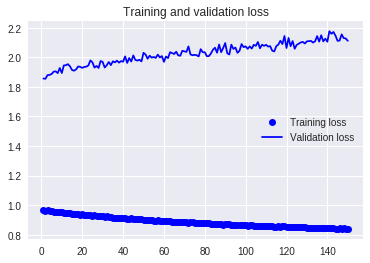

In [177]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
def sample(preds, temperature= 0.2):
    preds = np.reshape(preds,preds.shape[-1])
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)/ temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1,preds, 1)
    return np.argmax(probas)

In [0]:
def inference(sent):
  string_length=20
  string_revised=sent.ljust(string_length)
  return string_revised

In [238]:
start_word="lives"
inference_text = inference(start_word)

for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(inference_text.strip()+" ")
    generated_text = inference_text[:20]+""
    for i in range(100):
      sampled = np.zeros((1, max_len, len(word_index)))
      for t, char in enumerate(generated_text):
          sampled[0, t, word_index[char]] = 1.
      preds = model.predict(sampled, verbose=0)[0]
      next_index = sample(preds, temperature)
      next_char = index2char[next_index]
      generated_text += next_char
      generated_text = generated_text[1:]
      sys.stdout.write(next_char)
    print()

------ temperature: 0.2
lives of the world in the world alone, the past perace, that it can do it alone, and the reason and the do
------ temperature: 0.5
lives to so them. I've used the best areh, that I wanted to be alone that I was a really didn't ment a sho
------ temperature: 1.0
lives by anger may had the reason that is still even people to the day when you be good thing I find that 
------ temperature: 1.2
lives is callage creatamiks now. , thy Hounriple about the young pleHon late way. Amerates have of Newb.yr
